In [ ]:

!pip install stable-baselines3[extra]
!pip install gymnasium
!pip install rasterio
!pip install scikit-image
!pip install geopandas
!pip install rasterstats


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from tqdm import tqdm
import time
from google.colab import drive
drive.mount('/content/drive')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ValueError: mount failed

In [ ]:
from skimage.transform import resize

#file names
file_slope = '/content/drive/MyDrive/data_final/f_slope_60m.tif'
file_hazard = '/content/drive/MyDrive/data_final/f_hazard_60m.tif'
file_sunlight = '/content/drive/MyDrive/data_final/f_sunlight_60m.tif'
file_water = '/content/drive/MyDrive/data_final/f_water_60m.tif'


with rasterio.open(file_sunlight) as src:
    f_sunlight_norm = src.read(1)
    f_sunlight_norm = np.clip(f_sunlight_norm, 0, 1)
    TARGET_SHAPE = f_sunlight_norm.shape
    print(f"Sunlight layer loaded. Target Shape: {TARGET_SHAPE}")

with rasterio.open(file_water) as src:
    f_water_norm = src.read(1)

    if f_water_norm.shape != TARGET_SHAPE:
        print(f"Warning: Resizing water layer from {f_water_norm.shape} to {TARGET_SHAPE}")
        f_water_norm = resize(f_water_norm, TARGET_SHAPE, anti_aliasing=True, preserve_range=True)
    f_water_norm = np.clip(f_water_norm, 0, 1)
    print(f"Water layer loaded. Shape: {f_water_norm.shape}")

# Load and Normalize f_slope
with rasterio.open(file_slope) as src:
    f_slope = src.read(1)
    f_slope_norm = np.clip(f_slope, 0, 20) / 20.0
    f_slope_norm = 1.0 - f_slope_norm
    print(f"Slope layer loaded. Original shape: {f_slope.shape}")

    # RESIZE if it doesn't match
    if f_slope_norm.shape != TARGET_SHAPE:
        print(f"Resizing slope layer from {f_slope_norm.shape} to {TARGET_SHAPE}...")
        f_slope_norm = resize(f_slope_norm, TARGET_SHAPE, anti_aliasing=True, preserve_range=True)

# Load and Normalize f_hazard
with rasterio.open(file_hazard) as src:
    f_hazard = src.read(1)
    cap = np.percentile(f_hazard[~np.isnan(f_hazard)], 98)
    f_hazard_norm = np.clip(f_hazard, 0, cap) / cap
    f_hazard_norm = 1.0 - f_hazard_norm
    print(f"Hazard layer loaded. Original shape: {f_hazard.shape}")

    # RESIZE if it doesn't match
    if f_hazard_norm.shape != TARGET_SHAPE:
        print(f"Resizing hazard layer from {f_hazard_norm.shape} to {TARGET_SHAPE}...")
        f_hazard_norm = resize(f_hazard_norm, TARGET_SHAPE, anti_aliasing=True, preserve_range=True)

# Create the final 4-layer stack
# Shape will be (4, Height, Width)
feature_stack = np.stack([
    f_water_norm,      # Feature 0
    f_slope_norm,      # Feature 1 (1.0 = good/flat)
    f_sunlight_norm,   # Feature 2
    f_hazard_norm      # Feature 3 (1.0 = good/safe)
], axis=0)

# Get map dimensions
MAP_HEIGHT, MAP_WIDTH = feature_stack.shape[1:]
print(f"\n✅ Feature stack created successfully!")
print(f"Stack shape: {feature_stack.shape} (Features, Height, Width)")
print(f"Map dimensions: {MAP_HEIGHT} x {MAP_WIDTH}")

Loading rasters...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Sunlight layer loaded. Target Shape: (5058, 5058)
Water layer loaded. Shape: (5058, 5058)
Slope layer loaded. Original shape: (5056, 5056)
Resizing slope layer from (5056, 5056) to (5058, 5058)...
Hazard layer loaded. Original shape: (5056, 5056)
Resizing hazard layer from (5056, 5056) to (5058, 5058)...

✅ Feature stack created successfully!
Stack shape: (4, 5058, 5058) (Features, Height, Width)
Map dimensions: 5058 x 5058


In [ ]:
class MoonEnv(gym.Env):
    """
    Custom Environment for Lunar Landing Site Selection.

    - Observation: A single pixel's 4 features (water, slope, sunlight, hazard)
    - Action: 3 continuous values (weights for water, slope, sunlight)
    - Reward: A score based on the weighted sum + penalties for hazards.
    """
    def __init__(self, feature_stack):
        super(MoonEnv, self).__init__()

        self.stack = feature_stack
        self.height, self.width = self.stack.shape[1:]
        self.num_pixels = self.height * self.width
        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.current_pixel_index = 0

    def _get_obs(self):
        # Get the (row, col) from the 1D index
        row = self.current_pixel_index // self.width
        col = self.current_pixel_index % self.width
        obs = self.stack[:, row, col]
        return np.nan_to_num(obs, nan=0.0).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_pixel_index = np.random.randint(0, self.num_pixels)

        observation = self._get_obs()
        info = {}
        return observation, info

    def step(self, action):
        # Get Features
        features = self._get_obs()
        f_water = features[0]
        f_slope = features[1]    # 1.0 is good (flat)
        f_sun = features[2]
        f_hazard = features[3]   # 1.0 is good (safe)

        weights = np.exp(action) / np.sum(np.exp(action))
        w_water, w_slope, w_sun = weights

        suitability = (w_water * f_water) + \
                      (w_slope * f_slope) + \
                      (w_sun * f_sun)

        # Calculate Reward
        hazard_penalty = 0.0
        if f_hazard < 0.5:
            hazard_penalty = 5.0 * (1.0 - f_hazard) # Big penalty

        slope_penalty = 0.0
        if f_slope < 0.5:
            slope_penalty = 2.0 * (1.0 - f_slope) # Medium penalty

        # Final reward
        reward = suitability - hazard_penalty - slope_penalty


        self.current_pixel_index = (self.current_pixel_index + 1) % self.num_pixels

        terminated = False
        truncated = True

        observation = self._get_obs()
        info = {}

        return observation, float(reward), terminated, truncated, info

In [ ]:
print("Creating Moon Environment...")
env = MoonEnv(feature_stack)

print("Checking environment...")
check_env(env)
print("✅ Environment is valid!")

# Train the Agent
# PPO (Proximal Policy Optimization)
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log="/content/drive/MyDrive/data_final/ppo_moon_tensorboard/"
)

print("\n--- 🚀 Starting Training... ---")
start_time = time.time()
model.learn(total_timesteps=1000000)

end_time = time.time()
print(f"--- ✅ Training Complete! ---")
print(f"Total training time: {end_time - start_time:.2f} seconds")

model.save("/content/drive/MyDrive/data_final/ppo_moon_model")
print("Model saved as 'ppo_moon_model.zip'")

Creating Moon Environment...
Checking environment...
✅ Environment is valid!
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

--- 🚀 Starting Training... ---
Logging to /content/drive/MyDrive/data_final/ppo_moon_tensorboard/PPO_4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    std                  | 0.525        |
|    value_loss           | 237          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -0.505      |
| time/                   |             |
|    fps                  | 539         |
|    iterations           | 263         |
|    time_elapsed         | 998         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.011855565 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.5        |
|    n_updates            | 2620        |
|    policy_gradient_loss | -0.000134   |
|    std              

In [ ]:
print("Loading the trained model...")
model = PPO.load("/content/drive/MyDrive/data_final/ppo_moon_model")


MAP_HEIGHT, MAP_WIDTH = feature_stack.shape[1:]
suitability_map = np.zeros((MAP_HEIGHT, MAP_WIDTH), dtype=np.float32)
weights_map = np.zeros((3, MAP_HEIGHT, MAP_WIDTH), dtype=np.float32) # 3 layers for 3 weights

print(f"Generating suitability and weights maps for {MAP_HEIGHT}x{MAP_WIDTH} pixels...")


for r in tqdm(range(MAP_HEIGHT), desc="Processing Rows"):
    for c in range(MAP_WIDTH):
        obs = feature_stack[:, r, c]
        obs = np.nan_to_num(obs, nan=0.0).astype(np.float32)

        action, _states = model.predict(obs, deterministic=True)

        weights = np.exp(action) / np.sum(np.exp(action))
        w_water, w_slope, w_sun = weights

        weights_map[:, r, c] = weights

        f_water = obs[0]
        f_slope = obs[1]
        f_sun = obs[2]

        suitability_score = (w_water * f_water) + \
                            (w_slope * f_slope) + \
                            (w_sun * f_sun)

        suitability_map[r, c] = suitability_score

print("\nMaps generated!")

with rasterio.open('/content/drive/MyDrive/data_final/f_sunlight_60m.tif') as src:
    profile = src.profile

print("Saving final map as suitability_map.tif...")
profile.update(
    dtype=rasterio.float32,
    count=1,  # 1 layer
    compress='lzw'
)
with rasterio.open('/content/drive/MyDrive/data_final/suitability_map.tif', 'w', **profile) as dst:
    dst.write(suitability_map, 1)

print("Saving AI weights map as weights_map.tif...")
profile.update(
    dtype=rasterio.float32,
    count=3,  # 3 layers
    compress='lzw'
)
with rasterio.open('/content/drive/MyDrive/data_final/weights_map.tif', 'w', **profile) as dst:
    dst.write(weights_map, [1, 2, 3]) # Write all 3 bands


Loading the trained model...
Generating suitability and weights maps for 5058x5058 pixels...


Processing Rows:  49%|████▉     | 2476/5058 [1:45:46<1:45:28,  2.45s/it]

In [ ]:
# Find and Extract Top Candidate Zones

import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import pandas as pd
from rasterio.features import shapes

print("Loading suitability map...")
suitability_file = "/content/drive/MyDrive/data_final/suitability_map.tif"

with rasterio.open(suitability_file) as src:
    suitability_data = src.read(1)
    transform = src.transform
    crs = src.crs

threshold = np.percentile(suitability_data[suitability_data > 0], 95)
print(f"Calculated 'high score' threshold: {threshold:.4f} (Top 5% of sites)")

binary_map = (suitability_data >= threshold).astype(np.uint8)

print("Extracting candidate zones (pixels to polygons)...")

all_shapes = list(shapes(binary_map, mask=(binary_map == 1), transform=transform))

# Convert the shapes into a GeoDataFrame
features = [{"geometry": s, "properties": {"value": v}} for s, v in all_shapes]

if not features:
    print("No polygons found! Your map might be all black. Try lowering the percentile threshold (e.g., to 90).")
else:
    gdf = gpd.GeoDataFrame.from_features(features, crs=crs)
    # Add a unique ID for each landing zone
    gdf['zone_id'] = range(len(gdf))
    print(f"Found {len(gdf)} candidate landing zones!")

In [ ]:
!pip install geopandas
!pip install rasterstats
from rasterstats import zonal_stats
import geopandas as gpd

feature_files = {
    "Slope_mean": "/content/drive/MyDrive/data_final/f_slope_aligned.tif",
    "Hazard_mean": "/content/drive/MyDrive/data_final/f_hazard_aligned.tif",
    "Sunlight_mean": "/content/drive/MyDrive/data_final/f_sunlight_60m.tif",
    "Water_mean": "/content/drive/MyDrive/data_final/f_water_60m.tif"
}

print("Running Zonal Statistics (calculating mean feature values for each zone)...")


for col_name, filepath in feature_files.items():
    print(f"Calculating stats for {col_name}...")
    stats = zonal_stats(gdf, filepath, stats="mean")
    gdf[col_name] = [s['mean'] for s in stats]

print("Zonal Statistics complete!")


output_file = "/content/drive/MyDrive/data_final/Landing_Zones_with_Stats.gpkg"


gdf.to_file(output_file, driver="GPKG")

print(f"Zonal Statistics (GeoDataFrame) saved successfully to: {output_file}")

In [ ]:
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd

input_gpkg = "/content/drive/MyDrive/data_final/Landing_Zones_with_Stats.gpkg"
try:
    gdf = gpd.read_file(input_gpkg)
except Exception:
    print("Warning: Could not load GPKG file. Assuming 'gdf' GeoDataFrame is still in memory.")
weights_file = "/content/drive/MyDrive/data_final/weights_map.tif"

print("Running Zonal Statistics on AI Weights Map (this may take a moment)...")

stats_w_water = zonal_stats(gdf, weights_file, band=1, stats="mean")

stats_w_slope = zonal_stats(gdf, weights_file, band=2, stats="mean")

stats_w_sun = zonal_stats(gdf, weights_file, band=3, stats="mean")

gdf['AI_Water_Weight_mean'] = [s['mean'] for s in stats_w_water]
gdf['AI_Slope_Weight_mean'] = [s['mean'] for s in stats_w_slope]
gdf['AI_Sun_Weight_mean'] = [s['mean'] for s in stats_w_sun]

print("AI strategy analysis complete!")

output_file = "/content/drive/MyDrive/data_final/Landing_Zones_Analyzed.gpkg"
gdf.to_file(output_file, driver="GPKG")
print(f"Final analyzed GeoDataFrame saved successfully to: {output_file}")

In [ ]:
print("\n--- 📊 FINAL LANDING ZONE ANALYSIS 📊 ---")

import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
input_gpkg = "/content/drive/MyDrive/data_final/Landing_Zones_with_Stats.gpkg"
gdf = gpd.read_file(input_gpkg)
final_table = gdf.drop(columns=['geometry', 'value']).round(3)

print(final_table.to_string())

output_file = "/content/drive/MyDrive/data_final/Landing_Zones_Analyzed1.gpkg"
gdf.to_file(output_file, driver="GPKG")

print(f"\nFinal analysis table saved to {output_file}")
print("You can download this .gpkg file and open it in QGIS to see your final polygons.")

In [ ]:
# Cell 1: Install required packages
!pip install --quiet geopandas matplotlib pandas shapely fiona pygeos rtree


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path

INPUT_GPKG = "/content/drive/MyDrive/data_final/Landing_Zones_Analyzed.gpkg"
OUT_DIR = Path("/content/landing_zone_analysis_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Loading:", INPUT_GPKG)
gdf = gpd.read_file(INPUT_GPKG)
print("Columns:", list(gdf.columns))


ai_cols = ["AI_Water_Weight_mean", "AI_Slope_Weight_mean", "AI_Sun_Weight_mean"]

ai_means = gdf[ai_cols].mean()

ai_summary = {
    "AI_Water_Weight_mean": float(ai_means["AI_Water_Weight_mean"]),
    "AI_Slope_Weight_mean": float(ai_means["AI_Slope_Weight_mean"]),
    "AI_Sun_Weight_mean": float(ai_means["AI_Sun_Weight_mean"])
}

# Save summary
(OUT_DIR / "ai_strategy_summary.json").write_text(json.dumps(ai_summary, indent=2))
(OUT_DIR / "ai_strategy_summary.txt").write_text("AI Strategy Summary\n" + json.dumps(ai_summary, indent=2))

print("AI summary:", ai_summary)

# 2. Composite score
gdf["composite_score"] = (
    0.4 * gdf["Slope_mean"] +
    0.4 * gdf["Hazard_mean"] +
    0.2 * gdf["Sunlight_mean"]
)

# 3. Top zones
TOP_N = 10
top_zones = gdf.sort_values("composite_score", ascending=False).head(TOP_N)
top_zones.to_file(OUT_DIR / "top_zones.gpkg", driver="GPKG")
top_zones.drop(columns=["geometry"]).to_csv(OUT_DIR / "top_zones.csv", index=False)

print("Top zones saved.")

# 4. Descriptive statistics
desc = gdf[[
    "Slope_mean","Hazard_mean","Sunlight_mean","Water_mean",
    "AI_Water_Weight_mean","AI_Slope_Weight_mean","AI_Sun_Weight_mean"
]].describe().round(4)

desc.to_csv(OUT_DIR / "descriptive_statistics.csv")

# 5. Histograms
for c in ["Slope_mean","Hazard_mean","Sunlight_mean","Water_mean"]:
    plt.figure()
    plt.hist(gdf[c].dropna(), bins=60)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"hist_{c}.png", dpi=200)
    plt.close()

# 6. AI weight bar chart
plt.figure()
plt.bar(["Water","Slope","Sun"], [
    ai_summary["AI_Water_Weight_mean"],
    ai_summary["AI_Slope_Weight_mean"],
    ai_summary["AI_Sun_Weight_mean"]
])
plt.title("Mean AI Weights")
plt.ylabel("Mean Weight")
plt.tight_layout()
plt.savefig(OUT_DIR / "ai_weights_bar.png", dpi=200)
plt.close()

# 7. Case Study Zones
CASE_N = 5
case_zones = top_zones.head(CASE_N)

for _, row in case_zones.iterrows():
    zid = int(row["zone_id"])
    fig, ax = plt.subplots(figsize=(6,6))
    gdf.plot(ax=ax, alpha=0.05)
    gdf[gdf["zone_id"] == zid].plot(ax=ax, color="red")
    ax.set_title(f"Case Study Zone {zid}")
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"case_zone_{zid}.png", dpi=200)
    plt.close()
    # GeoJSON export
    gdf[gdf["zone_id"] == zid].to_file(OUT_DIR / f"case_zone_{zid}.geojson", driver="GeoJSON")

print("Case study zones saved.")

# 8. Summary report
report_text = f"""
AI Strategy Summary:
Water Weight Mean: {ai_summary['AI_Water_Weight_mean']}
Slope Weight Mean: {ai_summary['AI_Slope_Weight_mean']}
Sun Weight Mean:   {ai_summary['AI_Sun_Weight_mean']}

Top zones saved in: {OUT_DIR}
"""
(OUT_DIR / "summary_report.txt").write_text(report_text)

print(report_text)


In [ ]:
!pip install matplotlib

In [ ]:
from osgeo import gdal, ogr
import os

REFERENCE_TIF = "/content/drive/MyDrive/data_final/suitability_map.tif"
from osgeo import gdal, ogr
import shutil
import os

INPUT_TIF = "/content/drive/MyDrive/data_final/suitability_map.tif"

INPUT_GPKG = "/content/drive/MyDrive/data_final/landing_zone_analysis_outputs/top_zones.gpkg"

OUTPUT_TIF = "/content/drive/MyDrive/data_final/dem_with_zones_burned.tif"

BURN_VALUE = 50000


print(f"Copying {INPUT_TIF} to {OUTPUT_TIF}...")
if os.path.exists(OUTPUT_TIF):
    os.remove(OUTPUT_TIF) # Clean up previous run
shutil.copy(INPUT_TIF, OUTPUT_TIF)


print("Opening destination raster...")
tif_ds = gdal.Open(OUTPUT_TIF, gdal.GA_Update)

if tif_ds is None:
    raise Exception("Could not open the output TIF.")


print("Opening vector data...")
vec_ds = ogr.Open(INPUT_GPKG)
if vec_ds is None:
    raise Exception("Could not open the GPKG file.")

layer = vec_ds.GetLayer()
print(f"Burning polygons into raster with value {BURN_VALUE}...")

gdal.RasterizeLayer(
    tif_ds,
    [1],
    layer,
    burn_values=[BURN_VALUE],
    options=["ALL_TOUCHED=TRUE"]
)

tif_ds = None
vec_ds = None

print(f"Success! Created {OUTPUT_TIF}")

Copying /content/drive/MyDrive/data_final/suitability_map.tif to /content/drive/MyDrive/data_final/dem_with_zones_burned.tif...
Opening destination raster...
Opening vector data...
Burning polygons into raster with value 50000...
Success! Created /content/drive/MyDrive/data_final/dem_with_zones_burned.tif


Reading data...


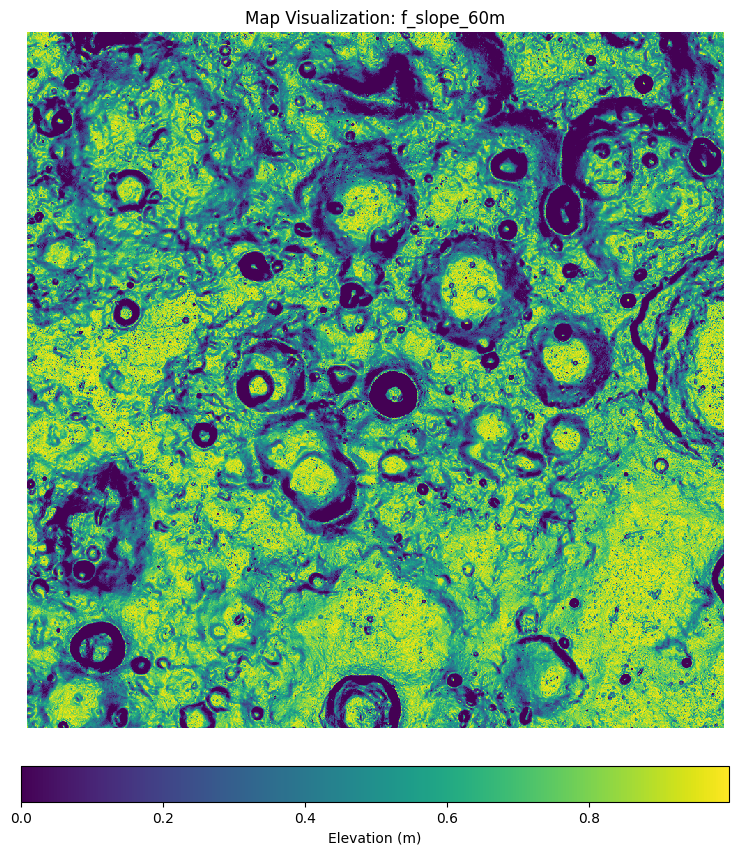

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/f_slope_aligned.tif"

if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize

    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading data...")
    data = ds.ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)

    data = data.astype(float)
    data[data < -10000] = np.nan

    plt.figure(figsize=(10, 10))


    img = plt.imshow(data, cmap='viridis', interpolation='nearest')

    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, fraction=0.046)

    cbar.set_label('Elevation (m)')
    plt.title(f"Map Visualization: f_slope_60m")
    plt.axis('off')
    plt.show()

Reading data...


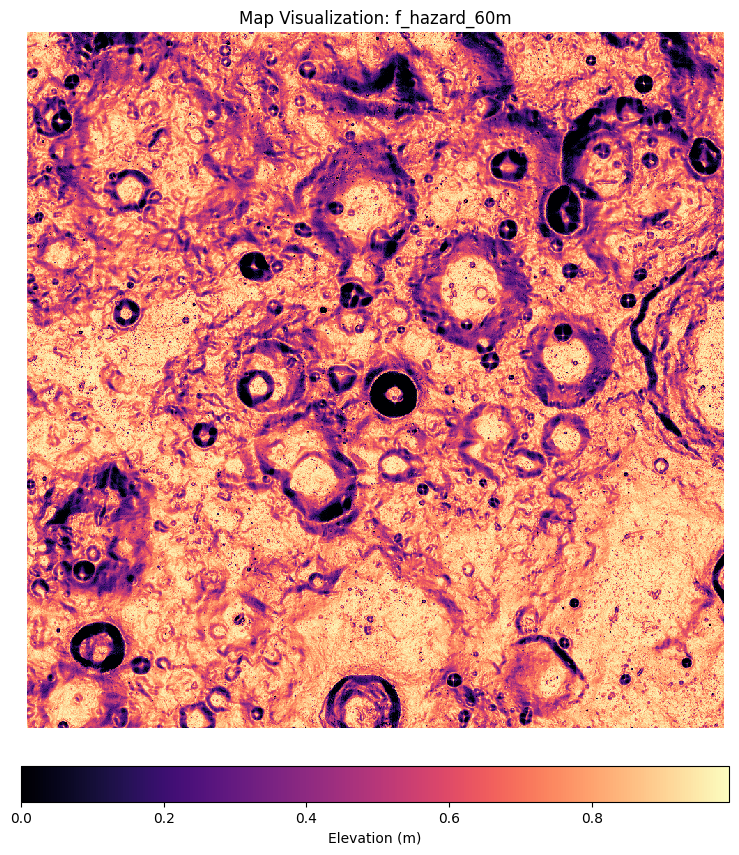

In [ ]:



from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/f_hazard_aligned.tif"

if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize

    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading data...")
    data = ds.ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)

    data = data.astype(float)
    data[data < -10000] = np.nan

    plt.figure(figsize=(10, 10))

    img = plt.imshow(data, cmap='magma', interpolation='nearest')

    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, fraction=0.046)

    cbar.set_label('Elevation (m)')

    plt.title(f"Map Visualization: f_hazard_60m")
    plt.axis('off')
    plt.show()



Reading data...


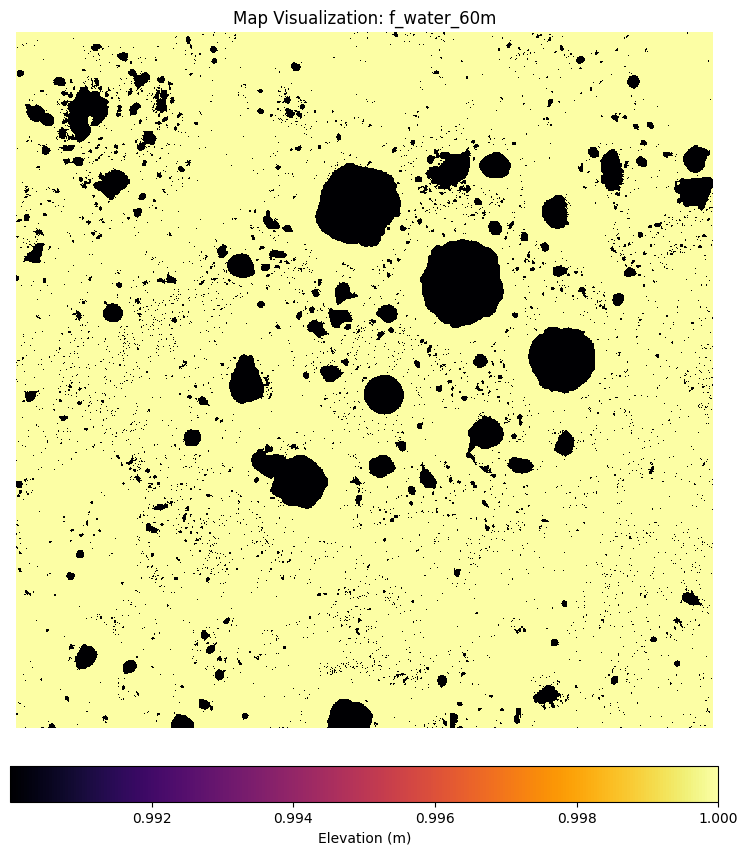

In [ ]:



from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/f_water_60m.tif"

if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize

    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading data...")
    data = ds.ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)

    data = data.astype(float)
    data[data < -10000] = np.nan

    plt.figure(figsize=(10, 10))


    img = plt.imshow(data, cmap='inferno', interpolation='nearest')


    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, fraction=0.046)

    cbar.set_label('Elevation (m)')

    plt.title(f"Map Visualization: f_water_60m")
    plt.axis('off')
    plt.show()



Reading data...


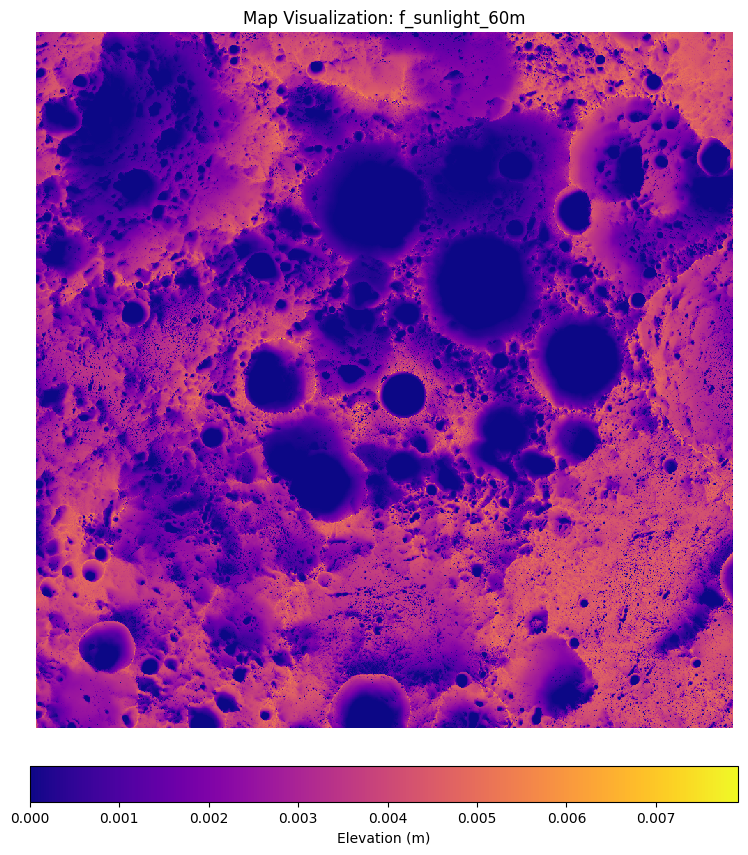

In [ ]:



from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/f_sunlight_60m.tif"

if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize

    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading data...")
    data = ds.ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)

    data = data.astype(float)
    data[data < -10000] = np.nan

    plt.figure(figsize=(10, 10))


    img = plt.imshow(data, cmap='plasma', interpolation='nearest')
    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, fraction=0.046)

    cbar.set_label('Elevation (m)')

    plt.title(f"Map Visualization: f_sunlight_60m")
    plt.axis('off')
    plt.show()




Reading data...


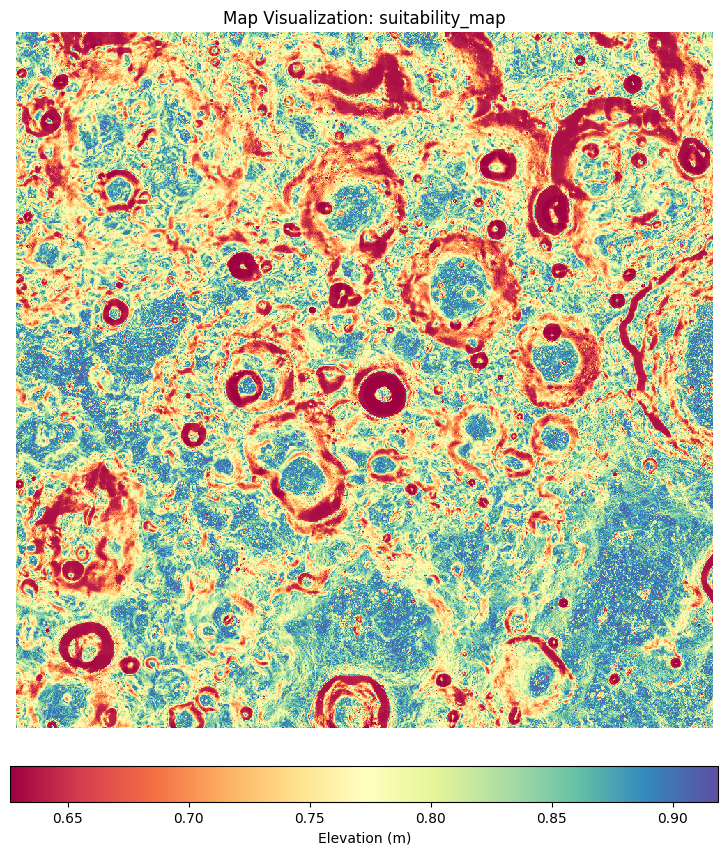

In [ ]:



from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/suitability_map.tif"


if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize
    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading data...")
    data = ds.ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)


    data = data.astype(float)
    data[data < -10000] = np.nan

    plt.figure(figsize=(10, 10))


    img = plt.imshow(data, cmap='Spectral', interpolation='nearest')

    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, fraction=0.046)

    cbar.set_label('Elevation (m)')

    plt.title(f"Map Visualization: suitability_map")
    plt.axis('off')
    plt.show()




In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import os

FILE_PATH = "/content/drive/MyDrive/data_final/weights_map.tif"

def normalize_band(band_data):
    band_data = band_data.astype(float)
    band_data[band_data < -10000] = np.nan

    valid_mask = ~np.isnan(band_data)
    if not np.any(valid_mask):
        return band_data

    vmin = np.nanmin(band_data)
    vmax = np.nanmax(band_data)

    if vmax == vmin:
        return np.zeros_like(band_data)

    return (band_data - vmin) / (vmax - vmin)

if not os.path.exists(FILE_PATH):
    print(f"Error: File not found at {FILE_PATH}")
else:
    ds = gdal.Open(FILE_PATH)
    width = ds.RasterXSize
    height = ds.RasterYSize

    target_width = 1000
    scale = target_width / width
    target_height = int(height * scale)

    print(f"Reading 3 bands...")
    r = ds.GetRasterBand(1).ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)
    g = ds.GetRasterBand(2).ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)
    b = ds.GetRasterBand(3).ReadAsArray(buf_xsize=target_width, buf_ysize=target_height)

    rgb_image = np.dstack((normalize_band(r), normalize_band(g), normalize_band(b)))
    rgb_image = np.nan_to_num(rgb_image)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(rgb_image)
    ax.set_title(f"RGB Composite:  weights_map")
    ax.axis('off')


    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='Band 1'),
        Patch(facecolor='#2bfb3d', edgecolor='black', label='Band 2'),
        Patch(facecolor='blue', edgecolor='black', label='Band 3')
    ]


    ax.legend(handles=legend_elements,
              loc='lower center',
              bbox_to_anchor=(0.5, -0.05),
              ncol=3,
              frameon=False,
              fontsize=12)

    plt.tight_layout()
    plt.show()

Reading 3 bands...
